In [1]:
import sys
sys.path.append('C:/Users/Fabian/gempy')
#sys.path.insert(0, '/home/bl9/gempy')
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import vtk
import evtk

from scipy.interpolate import griddata

import decision_making as dm

from skimage import measure
from scipy.spatial import distance

import scipy.signal as sg

C:/Users/Fabian/gempy\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
C:/Users/Fabian/gempy\gempy\data_management.py:35: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')


In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,1000,0,1000,0,1000],[50,50,50],
                         path_o = ".././input_data/simple_dome_orientations1.csv",
                         path_i = ".././input_data/simple_dome_points2.csv")
geo_data.n_faults = 0

In [3]:
gp.set_series(geo_data, {"Dome":('Shale')},
                       order_series = ["Dome",], order_formations=['Shale',])

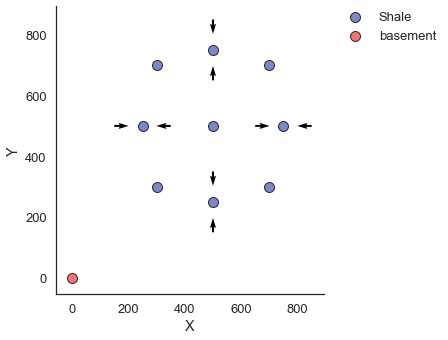

In [4]:
figsize(20,10)
gp.plotting.plot_data(geo_data,direction='z')

In [5]:
# Groups considering top view on spill line:
# From A to H clockwise, starting at center left
# Central points are a separate group (nan)

geo_data.interfaces['group_id']

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
6    6.0
7    7.0
8    NaN
9    NaN
Name: group_id, dtype: float64

In [6]:
interp_data = gp.InterpolatorData(geo_data,u_grade=[3],
                                  output='gradients', dtype='float64', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [7]:
lith_sol, fault_sol = gp.compute_model(interp_data)

In [8]:
base_n = int(geo_data.formations.loc['basement','formation_number'].values[0])
#sandstone_n = int(geo_data.formations.loc['Sandstone','formation_number'].values[0])
shale_n = int(geo_data.formations.loc['Shale','formation_number'].values[0])

In [9]:
#sst_surf_v, sst_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = sandstone_n)
shale_surf_v, shale_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = shale_n)

In [10]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

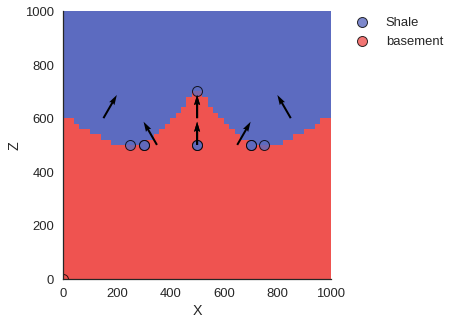

In [11]:
%matplotlib inline
figsize(20,10)
gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data=1, direction='y')

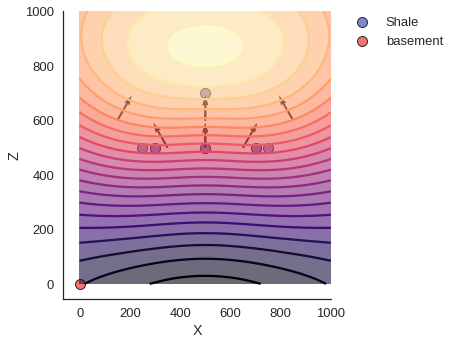

In [12]:
%matplotlib inline
figsize(20,10)
gp.plotting.plot_scalar_field(geo_data, lith_sol[1], 
                              0,
                              plot_data=1, direction='y')

In [13]:
importlib.reload(np)
a = np.zeros_like(lith_sol[3])

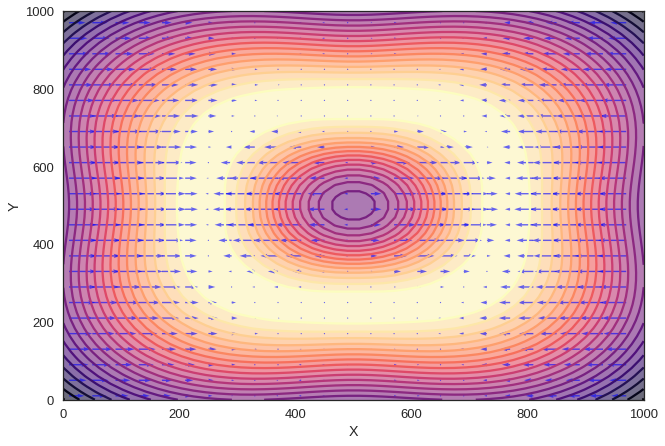

In [14]:
gp.plot_gradient(geo_data, lith_sol[1], lith_sol[2], a, lith_sol[4], 
                 cell_number=25, direction='z', quiver_stepsize=2)

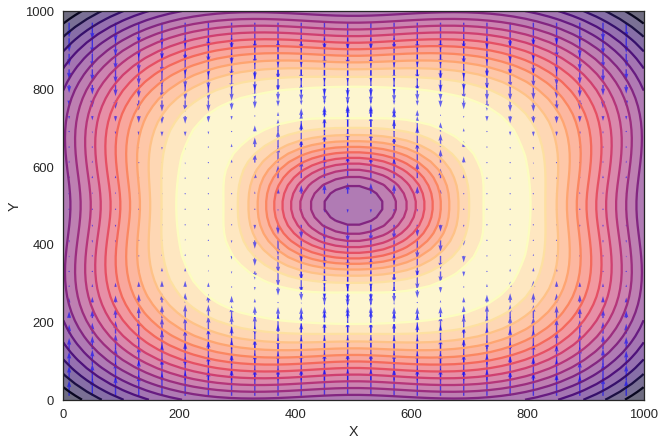

In [15]:
gp.plot_gradient(geo_data, lith_sol[1], a, lith_sol[3], lith_sol[4], 
                 cell_number=26, direction='z', quiver_stepsize=2)

In [16]:
# reshaping and naming the three gradient solutions accordingly
gx = lith_sol[2].reshape(resolution,resolution,resolution)
gy = lith_sol[3].reshape(resolution,resolution,resolution)
gz = lith_sol[4].reshape(resolution,resolution,resolution)

In [63]:
# using marching cubes to aquire surfaces (vertices, simplices) that align
# with the occurrence of zeros of the gradients (gradient minima)
v_gx0, s_gx, n_gx, val_gx = measure.marching_cubes_lewiner(gx, 0)
v_gy0, s_gy, n_gy, val_gy = measure.marching_cubes_lewiner(gy, 0)

In [65]:
v_gx0.shape, v_gy0.shape # note: v_gy0 longer than v_gx0 after marching cube application

((10622, 3), (10624, 3))

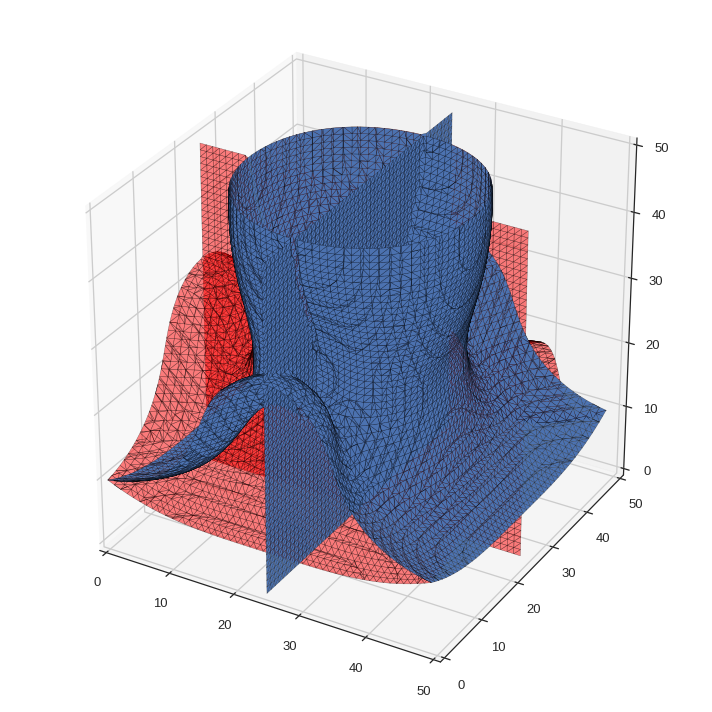

In [376]:
# 3D visualization of both surfaces attained via marching cubes
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(v_gx0[s_gx], alpha=0.5)
mesh.set_edgecolor('k')

mesh2 = Poly3DCollection(v_gy0[s_gy], alpha=0.5)
mesh2.set_edgecolor('k')
mesh2.set_facecolor('r')
ax.add_collection3d(mesh2)
ax.add_collection3d(mesh)

ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 50)  # b = 10
ax.set_zlim(0, 50)  # c = 16

plt.tight_layout()
plt.show()

In [66]:
# scaling from voxels up to meters using the original extent
v_gx = v_gx0 * (geo_data.extent[1]/resolution)
v_gy = v_gy0 * (geo_data.extent[3]/resolution)

In [69]:
# calculating euclidean distance between both surface vertices
dist_gxy = distance.cdist(v_gx,v_gy, 'euclidean')
dist_gxy.shape

In [72]:
# get distance minima and minima positions for both vertices groups
# this way we can pair 2 vertices from gx and gy based on their 
# common distance which is to be minimal (smaller than to all other points)
minx = np.min(dist_gxy, axis=1)
miny = np.min(dist_gxy, axis=0)
minx_pos = np.argmin(dist_gxy, axis=1)
miny_pos = np.argmin(dist_gxy, axis=0)

In [360]:
# set a cut-off value for minimal distance (here: 20 = voxelsize)
gx_cut_bool = minx < 20
gy_cut_bool = miny < 20

In [364]:
# need to pair the vertices of one group to those of the other
# for this we actually only need the minima positions of one vertices group
vgy_paired = v_gy[minx_pos]
### pair the mins of the shorter array onto the longer array

In [361]:
# limit (cut down) the vertices groups to only those 
# below the defined distance threshold
vgx_cut = v_gx[gx_cut_bool]
vgy_cut = vgy_paired[gx_cut_bool]

In [373]:
# now that we have one group (V1) and their according pairs (V2),
# we can get the mean of the distances to acquire new group of
# vertices that minimizes the error
V1=vgx_cut
V2=vgy_cut
V_mean = (V1+V2)/2

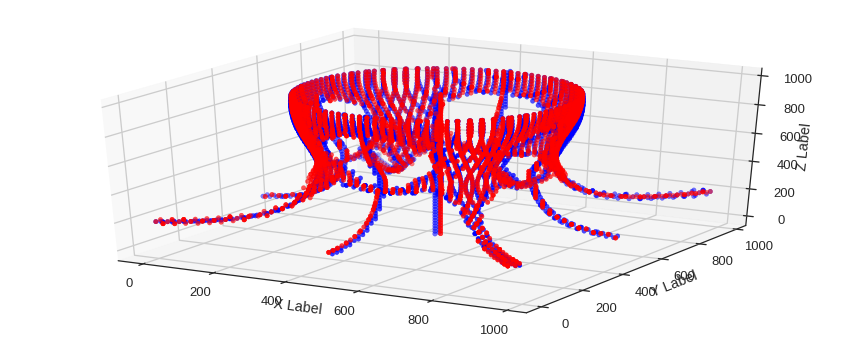

In [374]:
# plotting of the two original groups, but limited
%matplotlib inline
figsize(15,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vgx_cut[:,0],vgx_cut[:,1],vgx_cut[:,2], color='b')
ax.scatter(vgy_cut[:,0],vgy_cut[:,1],vgy_cut[:,2], color='r')
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

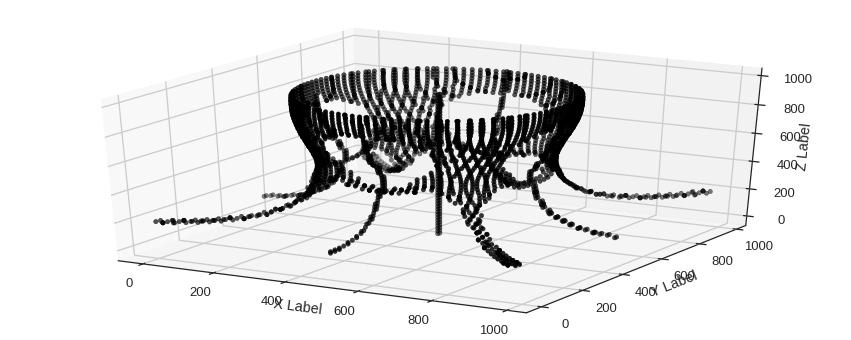

In [375]:
# plotting of the final mean group of vertices, limited according to the threshold
%matplotlib inline
figsize(15,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V_mean[:,0],V_mean[:,1],V_mean[:,2], color='k')
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [94]:
# get layer surface vertices
v_layer,s_layer = gp.get_surfaces(interp_data, lith_sol[1])
v_l = np.array(v_layer[0])

In [370]:
# get distance between gradient minima vertices and layer surface vertices
lmin_dist = distance.cdist(V_mean, v_l)

In [371]:
# find intersect between gradient minima and surface (same procedure as above)
min_dist = np.min(lmin_dist, axis=0)
l_cut_bool = min_dist < 20
intersect = v_l[l_cut_bool]

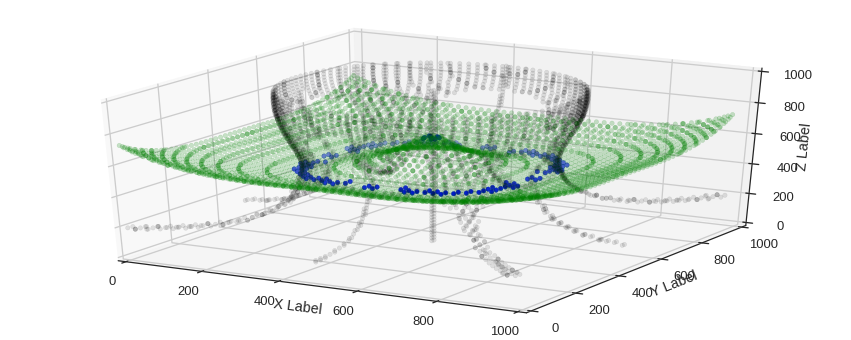

In [372]:
# 3D plotting of intersection
figsize(15,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V_mean[:,0],V_mean[:,1],V_mean[:,2], color='k', alpha=0.1)
ax.scatter(v_l[:,0],v_l[:,1],v_l[:,2], color='g', alpha=0.2)
ax.scatter(intersect[:,0],intersect[:,1],intersect[:,2], color='b')
#ax.scatter(intersect_y[:,0],intersect_y[:,1],intersect_y[:,2], color='r')

ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
ax.set_zlim(0,1000)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
def spill_leak_P(interp_data, res_surf, lith, fault_presence = geo_data.n_faults, print_figures=True):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.values[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.values[:, 1]))

    #grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    #grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    grid_x=(grid_x)-(np.min(grid_x))
    grid_y=(grid_y)-(np.min(grid_y))
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 5
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    
    #fault_max_line_bool = np.copy(grid_maxX)
    #fault_max_line = fault_max_line_bool.argmax(axis=1)
    #fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    #fleak_line = np.copy(grid_minX).astype(int)
    #fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering
    # to set neighboring values of min and max to min and max respectively, too 
    #if minmax_buffer:
    #    minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
    #    minXroll1[:,:fault_max] = 0
    #    minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
    #    minXroll2[:,:fault_max] = 0
    #    minXbuffer = np.logical_or(minXroll1, minXroll2)
    #    grid_minX = np.logical_or(grid_minX, minXbuffer)
    #    #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
    #    #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
    #    #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
    #    #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
    #    grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
    #    grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    if fault_presence == 0:
        print('NO FAULT PRESENT')
        pot_spill_points = saddle_p_all
        
        pot_spill_Xcoord = grid_x[pot_spill_points]
        pot_spill_Ycoord = grid_y[pot_spill_points]
        pot_spill_Zcoord = grid_z0[pot_spill_points]    
        pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
        
        if pot_spill_3Dcoord.size == 0:
            anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
            anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:]
            
        if print_figures==True:
            figsize(15,6)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
            #ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
            #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
            #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            plt.show()
        
            # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
            fault_leak_3Dcoord = np.nan
            plot_spill(res_surf, pot_spill_points, anticline_spill_3Dcoord, grid_x, grid_y, grid_z0)
        
        return anticline_spill_3Dcoord, np.nan
    
    else:          
    
        # distinguish anticlinal spill points from fault leak points:
        pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
        pot_spill_points = saddle_p_all - pot_leak_points   # substracting leak bool from saddle point bool 
                                                            # to get spill point bool    
        # leak and spill point 3D coordinates
        # LEAK POINT
        pot_leak_Xcoord = grid_x[pot_leak_points]
        pot_leak_Ycoord = grid_y[pot_leak_points]
        pot_leak_Zcoord = grid_z0[pot_leak_points]    
        pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
            
        if pot_leak_3Dcoord.size == 0:
            fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
            fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
            
        # SPILL POINT
        pot_spill_Xcoord = grid_x[pot_spill_points]
        pot_spill_Ycoord = grid_y[pot_spill_points]
        pot_spill_Zcoord = grid_z0[pot_spill_points]    
        pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
        
        if pot_spill_3Dcoord.size == 0:
            anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
            anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
        # PLOTTING (for visualization and checking)
        # plot of min/max bools and all potential LPs(+) and SPs(x):
        if print_figures==True:
            figsize(15,6)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
            ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
            #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
            #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            plt.show()
        
            # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
            plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
        
        return anticline_spill_3Dcoord, fault_leak_3Dcoord

def plot_spill(res_surface, pot_spills, spill_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:     
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [27]:
def rotate_dome(orig_v, roll_n, unc_z):
    #roll array of z-values so that 'start' is at [0]
    circle_z = np.roll(orig_v, -roll_n)
    circle_z[0] = orig_v[0] + unc_z
    circle_z[1] = orig_v[1] + (unc_z/2)
    circle_z[2] = orig_v[2]
    circle_z[3] = orig_v[3] - (unc_z/2)
    circle_z[4] = orig_v[4] - unc_z
    circle_z[5] = orig_v[5] - (unc_z/2)
    circle_z[6] = orig_v[6] 
    circle_z[7] = orig_v[7] + (unc_z/2)
    changed_z = np.roll(circle_z, roll_n)
    return changed_z

In [ ]:
# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    

original_values = interp_data.geo_data_res.interfaces.loc[0:7,'Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_unc = 30 #* unc_f

z_unc = pymc.Normal('z_unc', 0, 1./np.square(std_unc/rescale_f))

#start_unc = np.random.randint(8)

Variation by: -1.38322879206
Start at point: 4
NO FAULT PRESENT


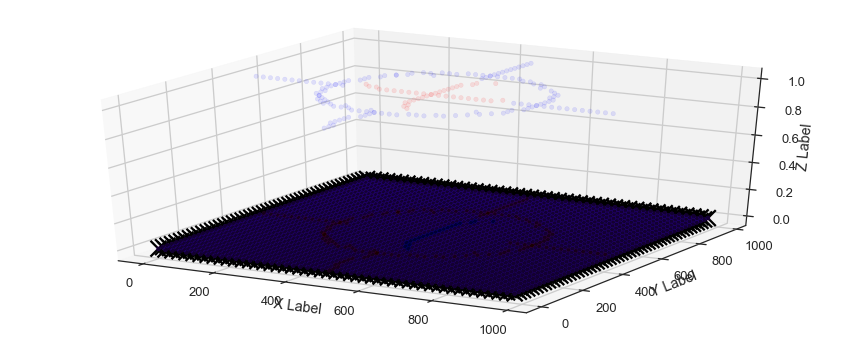

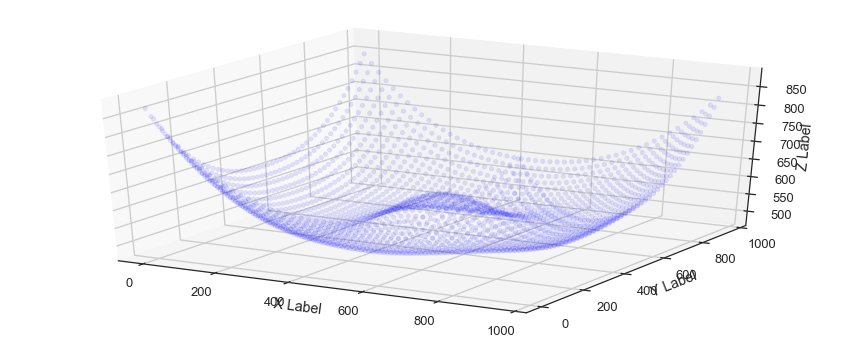

[] nan


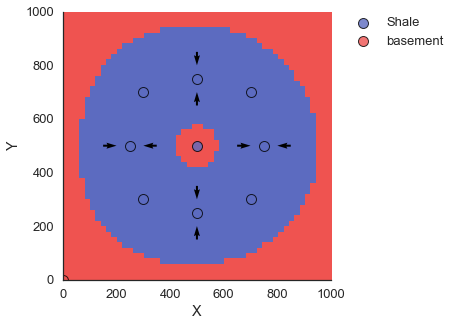

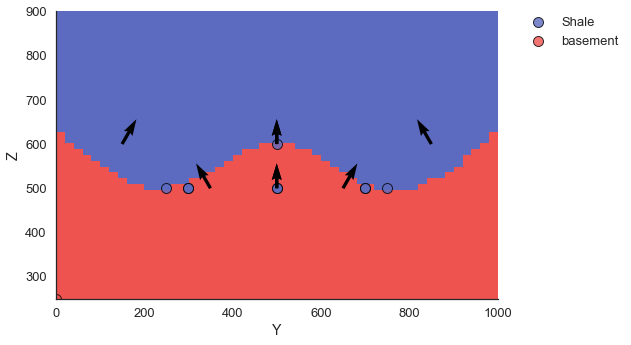

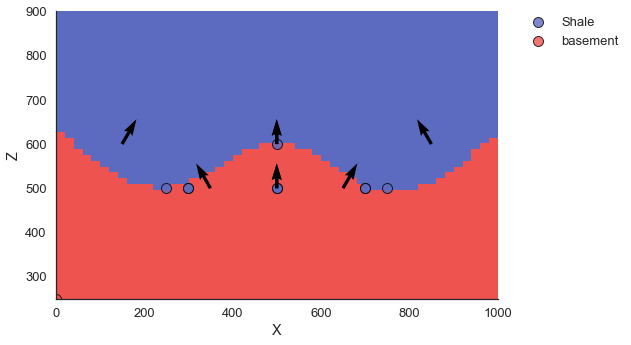

In [29]:
@pymc.deterministic
def interp_unc(value=0, z_unc=z_unc, original_values=original_values):
    
    print('Variation by:', z_unc*rescale_f)
    
    ### Declare on the the points on the contour closure (circle) to be
    ### assigned the starting uncertainty
    ### (COULD ALSO MAKE THIS TO DEPEND ON ITER TO CONTROL)
    start = 3#np.random.randint(8)
    print('Start at point:', start+1)
    #start_bool = interp_data.geo_data_res.interfaces['group_id'] == start
    #start_point = interp_data.geo_data_res.interfaces[start]
    
    #point_range = len(original_values)
    
    # change z_values on circle contour based on uncertainty variation
    changed_values = rotate_dome(original_values, start, z_unc)     
    
    # insert new changed values into interp_data
    interp_data.geo_data_res.interfaces.loc[0:7,'Z'] = changed_values
   
    return interp_data

@pymc.deterministic
def structural_model(interp_data_M=interp_unc, shale_n=shale_n, print_figures=True):
    lith_sol, fault_sol = gp.compute_model(interp_data_M)
    lith_block = lith_sol[0]
    
    #fault_block = fault_sol[0]  
    shale_surf_v, shale_surf_s = gp.get_surfaces(\
        interp_data = interp_data_M, potential_lith=lith_sol[1], n_formation = shale_n)
    #max_vol, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, seal_surf_v, seal_th)
    #print("Maximum trap volume: %s m³" % max_vol)
    a_spill, f_leak = spill_leak_P(interp_data_M, shale_surf_v, lith_block, geo_data.n_faults, print_figures)
    print(a_spill, f_leak)
    
    if print_figures:
        plt.figure(1)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='z')
        plt.figure(2)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='x')
        plt.figure(3)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='y')
        #gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return lith_sol#, fault_sol, max_vol, trap, SSF, trap_control


In [ ]:
iterations = 10
model = pymc.Model([interp_unc, z_unc, structural_model])

Variation by: 51.621160778
Start at point: 4
NO FAULT PRESENT


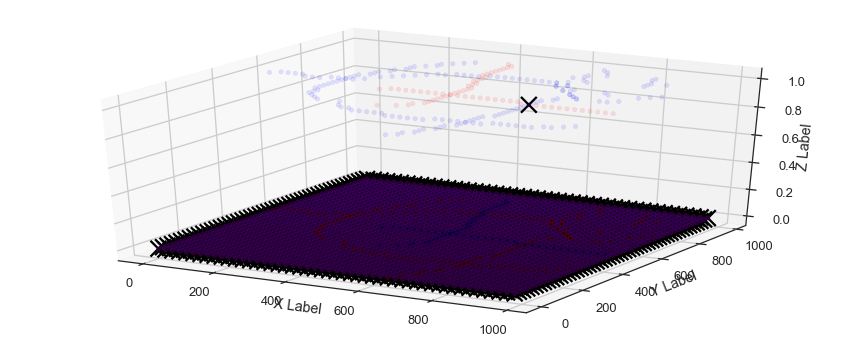

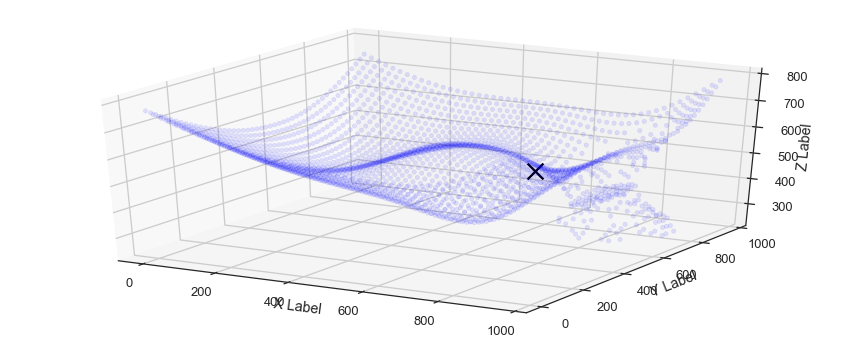

[ 740.          480.          535.56121826] nan
 [-------          20%                  ] 2 of 10 complete in 2.6 secVariation by: 11.7712469123
Start at point: 4
NO FAULT PRESENT


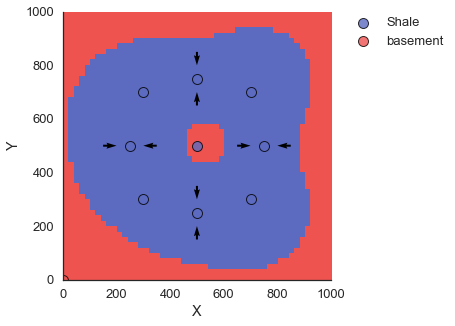

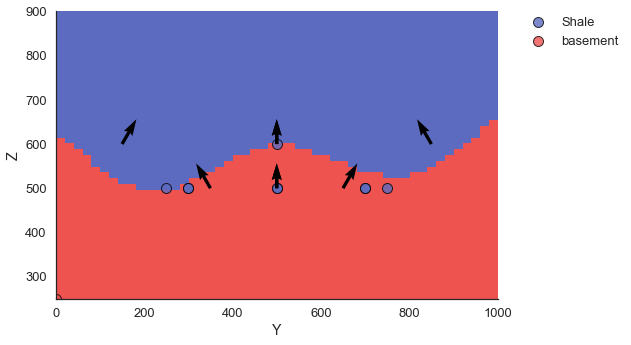

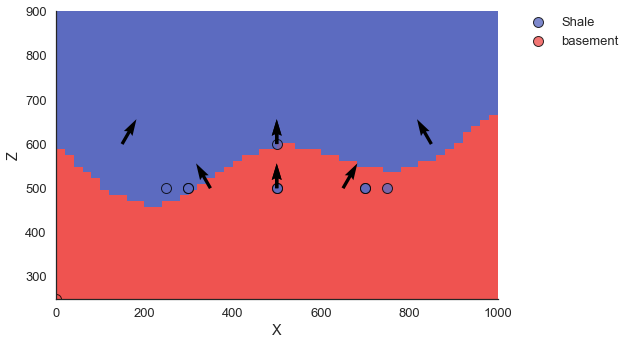

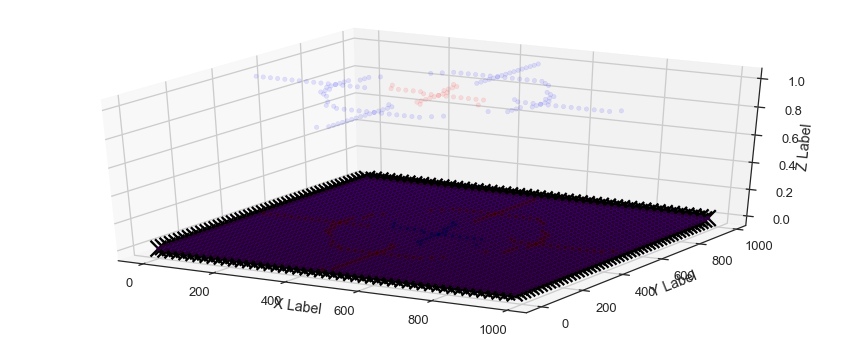

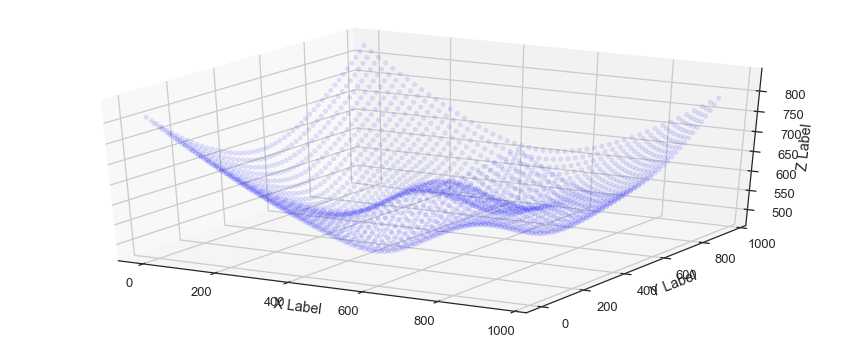

[] nan
 [-----------      30%                  ] 3 of 10 complete in 5.6 secVariation by: 8.02264732605
Start at point: 4
NO FAULT PRESENT


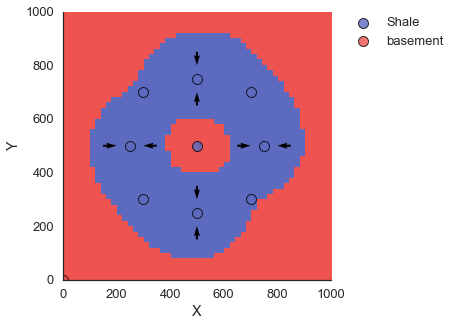

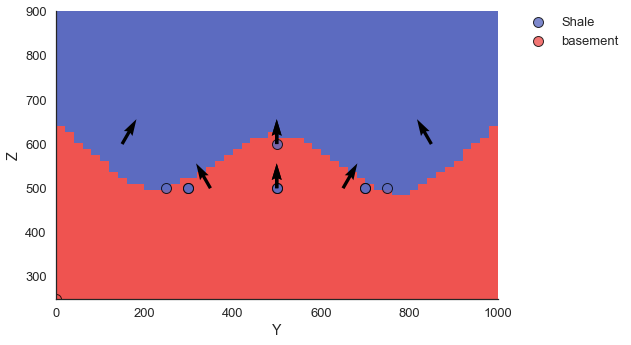

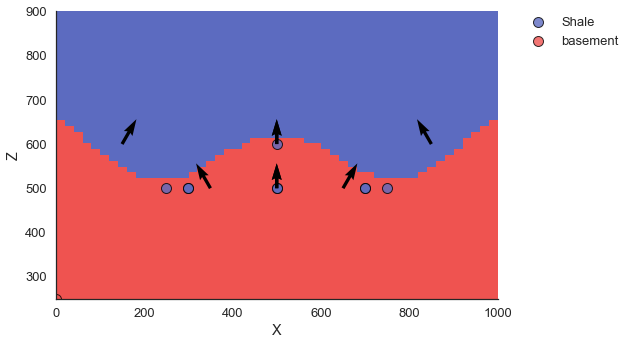

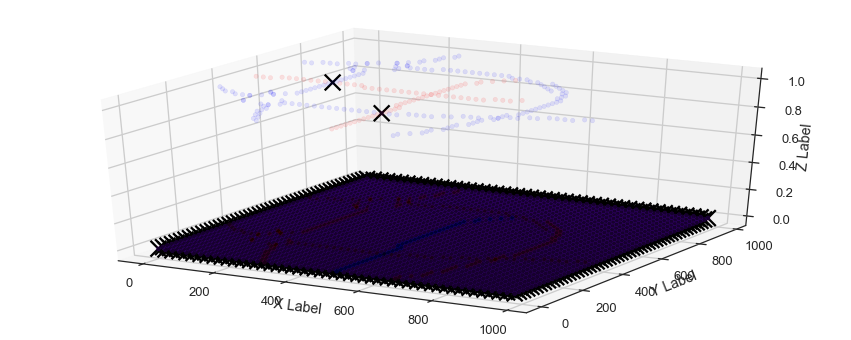

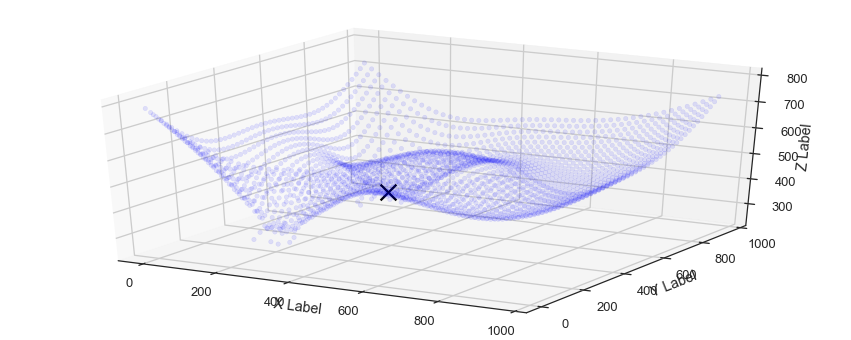

[ 500.          220.          493.05262566] nan
 [---------------  40%                  ] 4 of 10 complete in 8.5 secVariation by: -23.6940869331
Start at point: 4
NO FAULT PRESENT


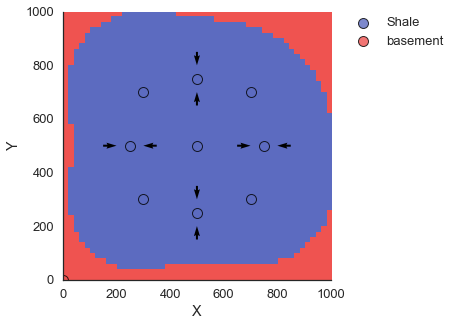

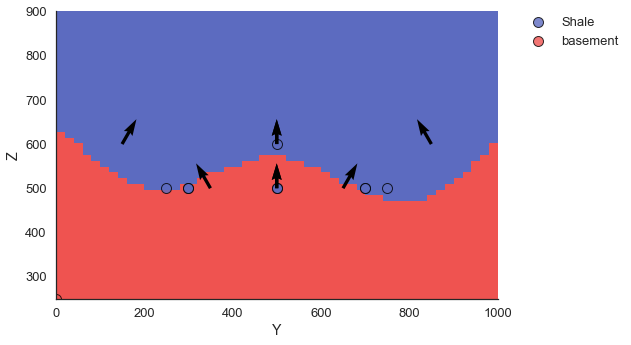

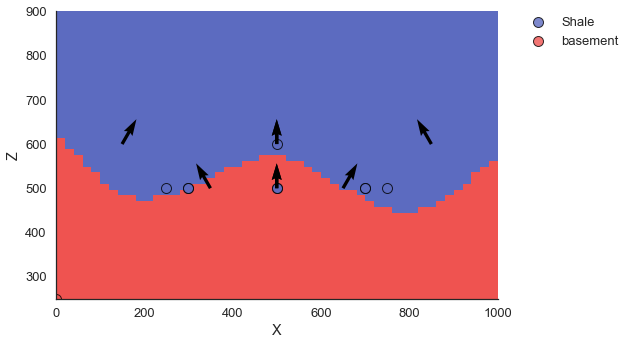

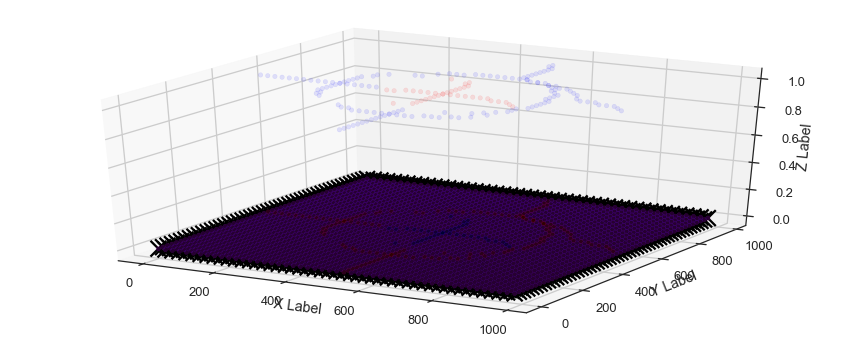

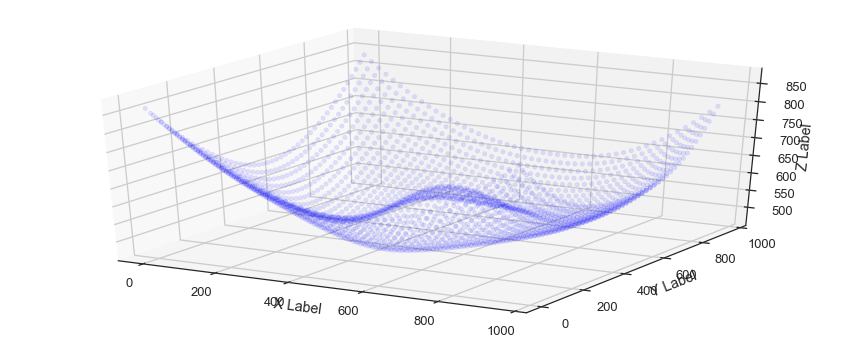

[] nan
 [-----------------50%                  ] 5 of 10 complete in 11.4 secVariation by: -8.39299257888
Start at point: 4
NO FAULT PRESENT


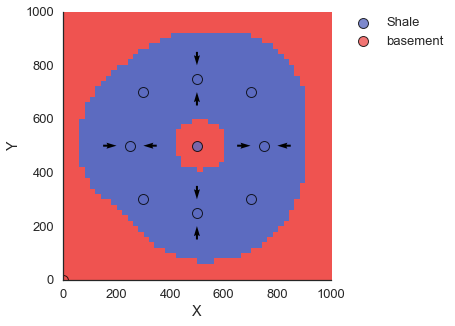

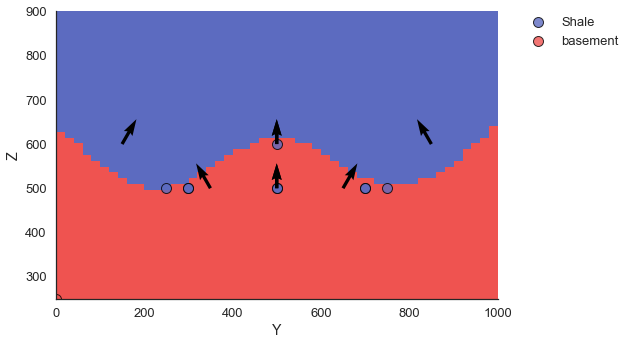

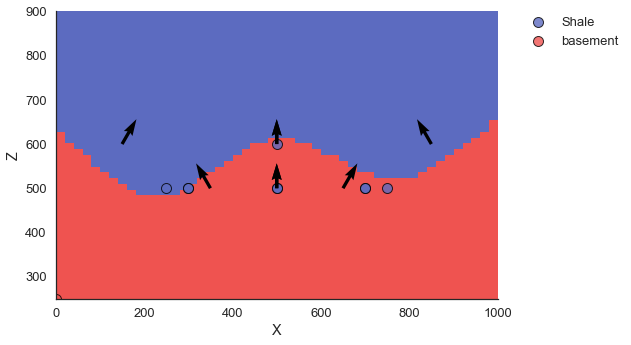

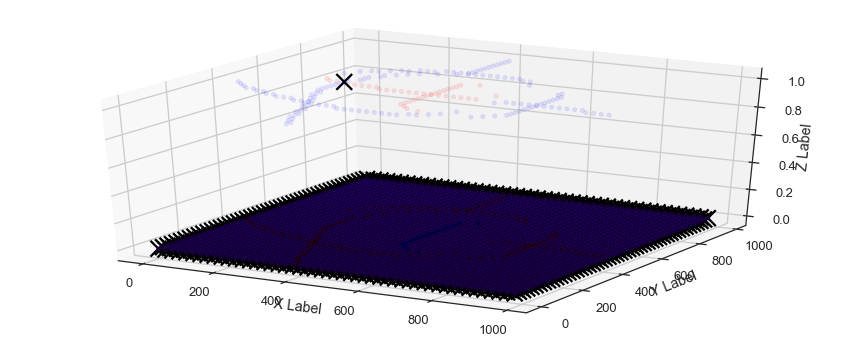

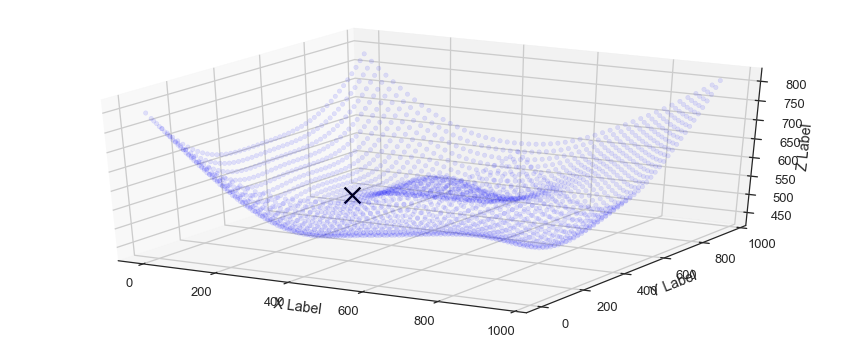

[ 220.          520.          505.82185364] nan
 [-----------------60%--                ] 6 of 10 complete in 14.2 secVariation by: 36.731269911
Start at point: 4
NO FAULT PRESENT


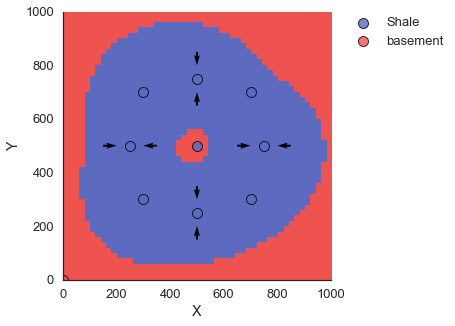

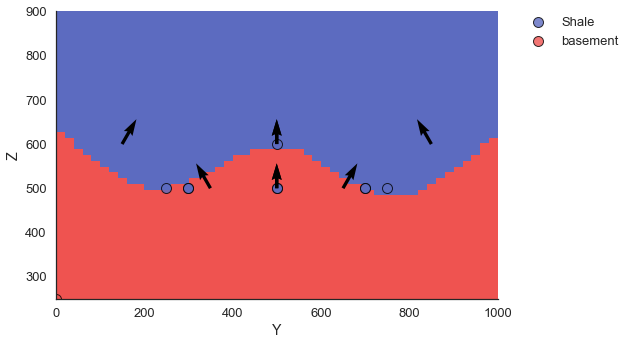

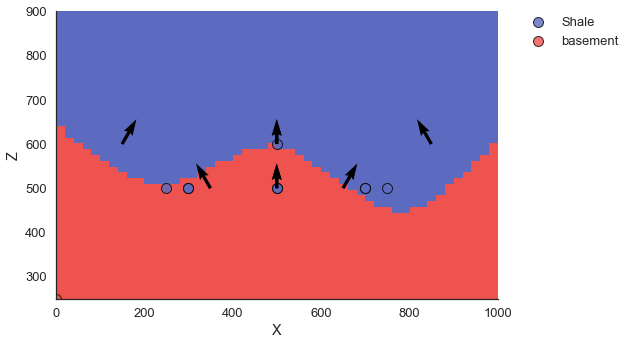

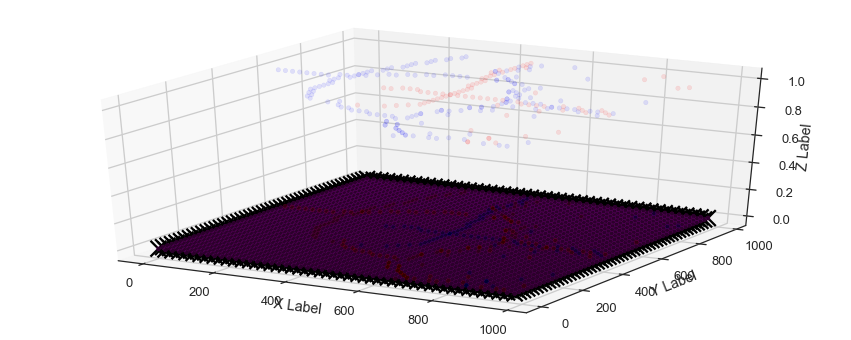

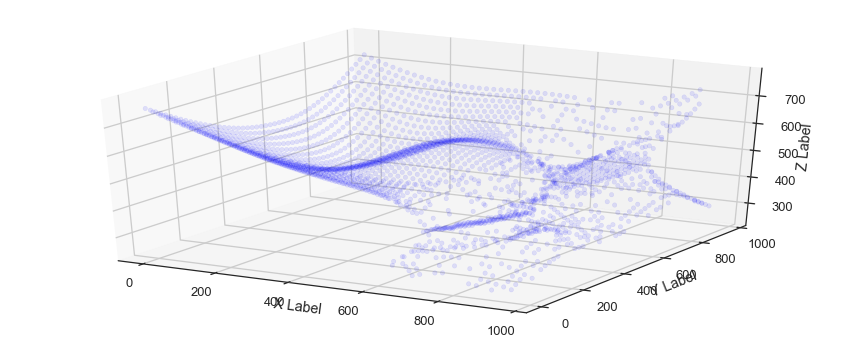

[] nan
 [-----------------70%------            ] 7 of 10 complete in 17.2 secVariation by: -20.9925037433
Start at point: 4
NO FAULT PRESENT


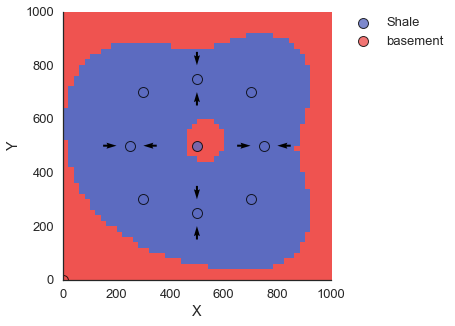

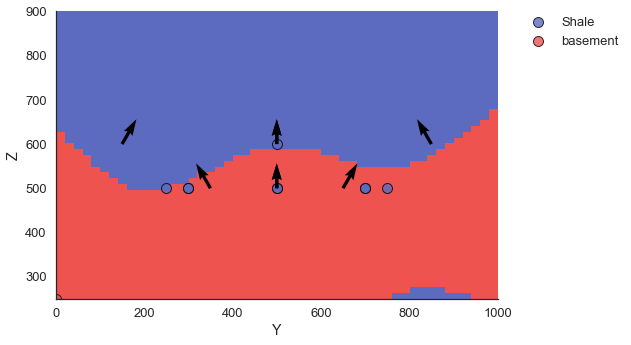

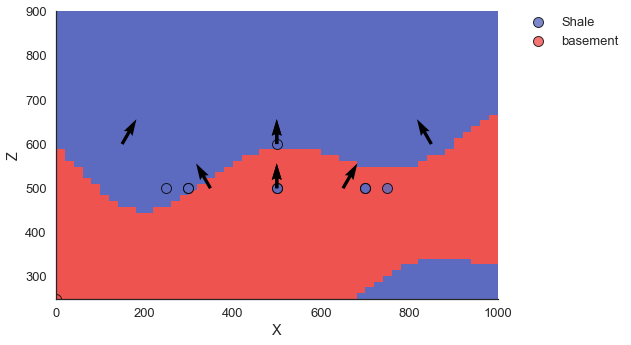

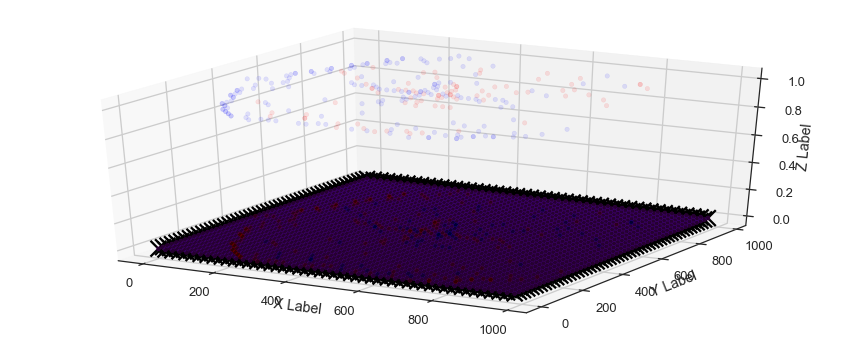

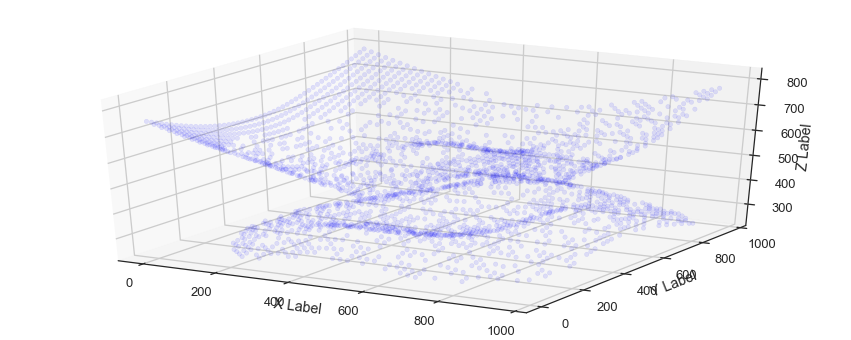

[] nan
 [-----------------80%----------        ] 8 of 10 complete in 20.1 secVariation by: -5.9520645768
Start at point: 4
NO FAULT PRESENT


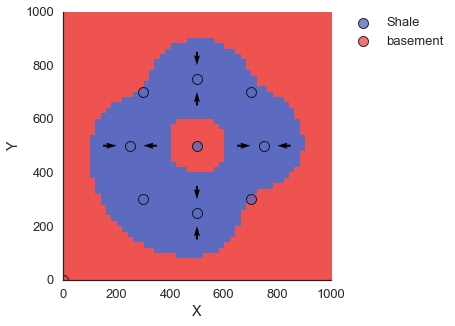

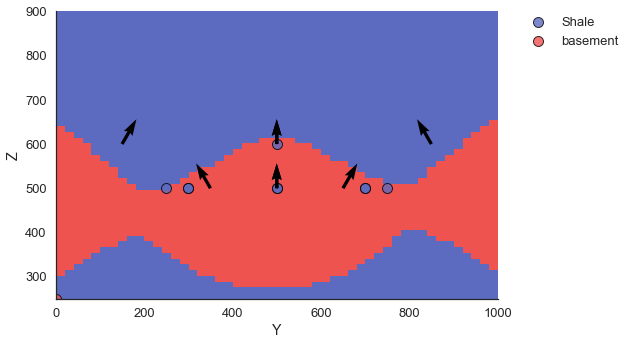

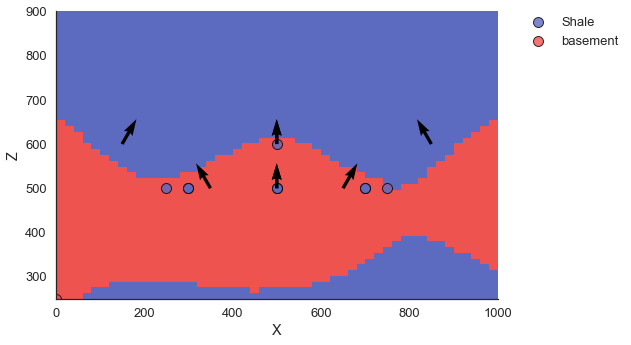

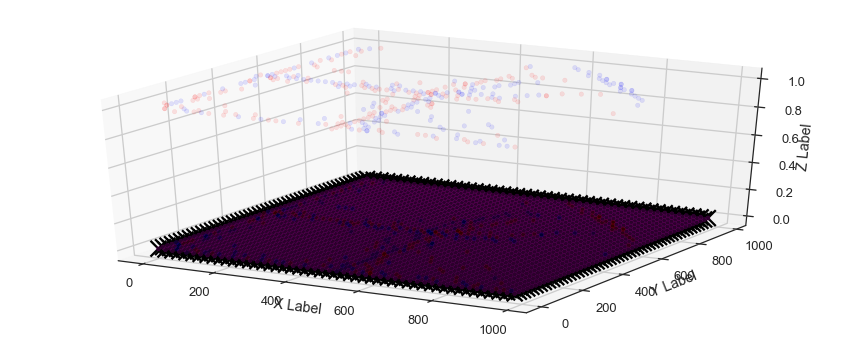

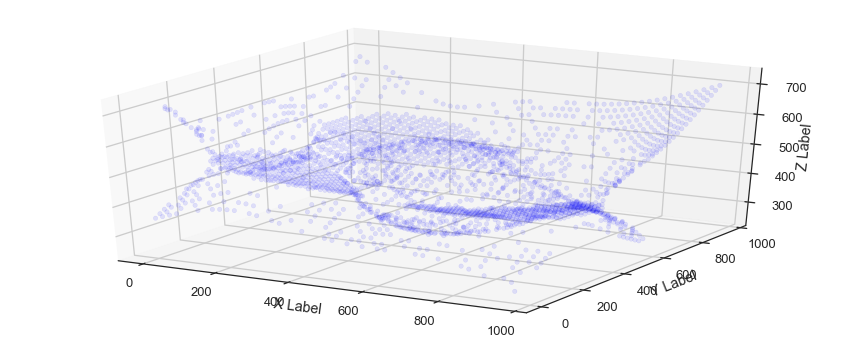

[] nan
 [-----------------90%--------------    ] 9 of 10 complete in 22.9 secVariation by: 12.7808298239
Start at point: 4
NO FAULT PRESENT


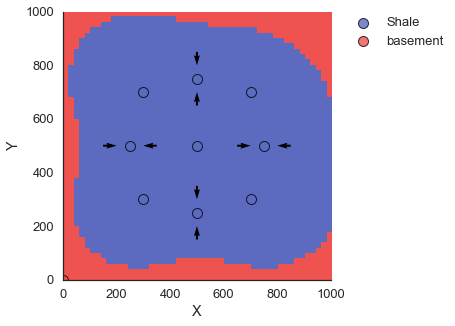

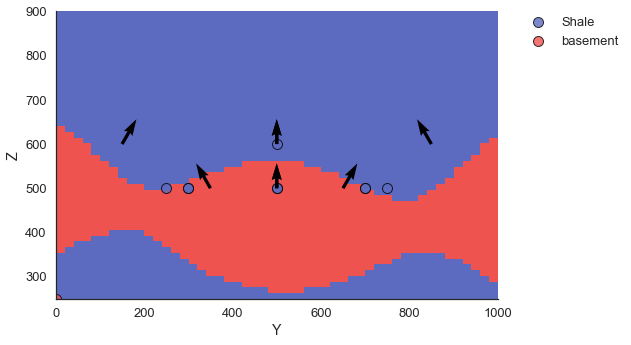

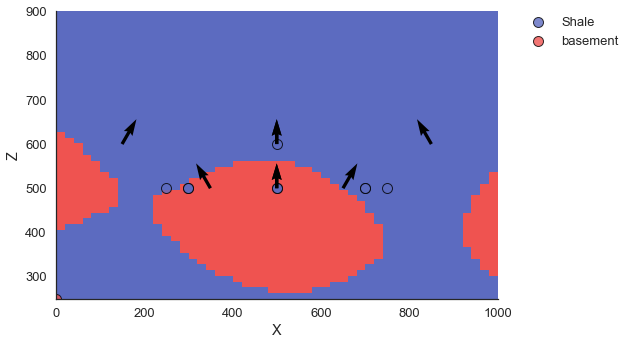

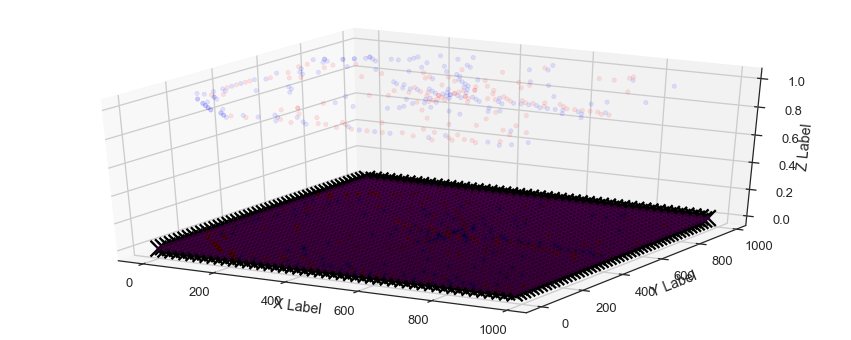

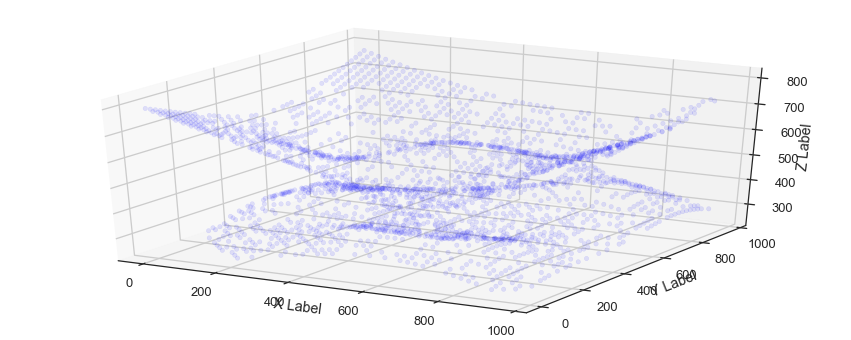

[] nan
 [-----------------100%-----------------] 10 of 10 complete in 25.9 secVariation by: 41.3760542335
Start at point: 4
NO FAULT PRESENT


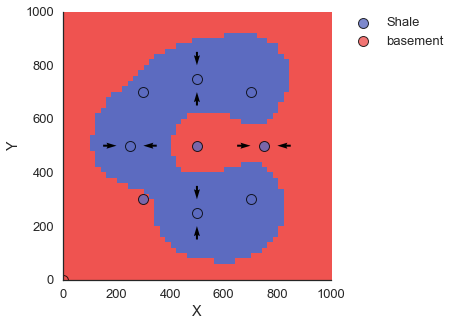

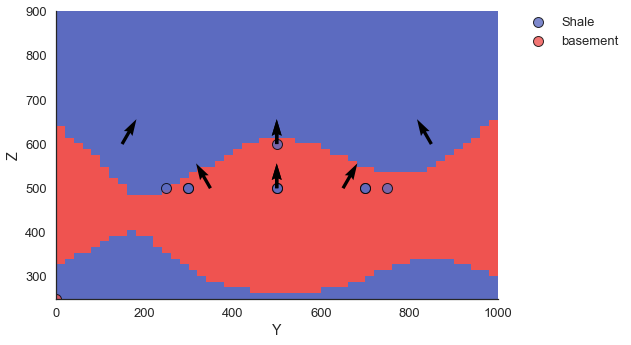

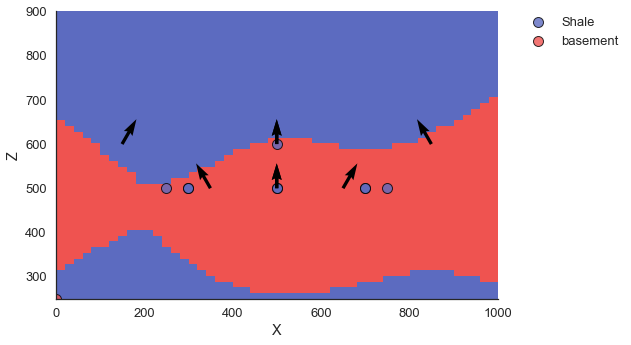

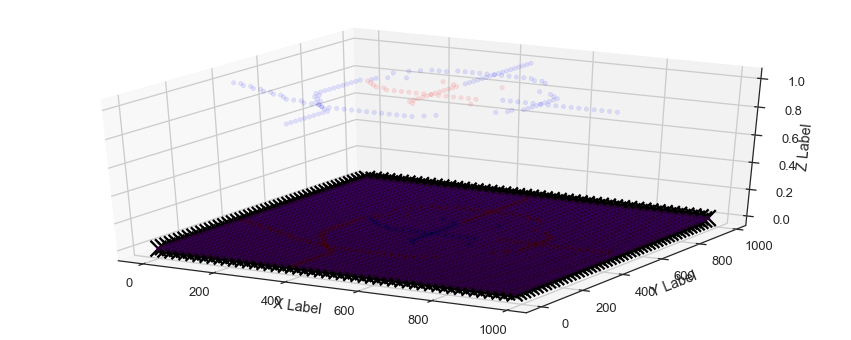

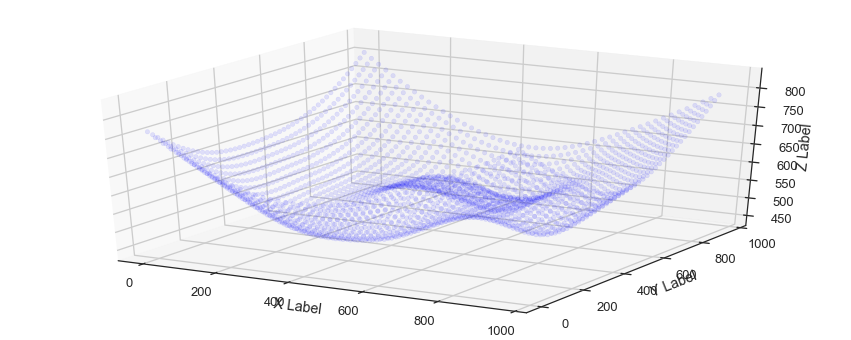

[] nan
 [------------------110%-------------------] 11 of 10 complete in 28.7 sec

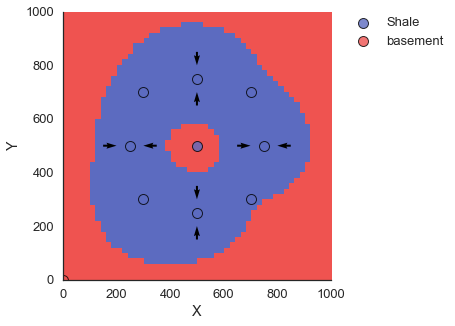

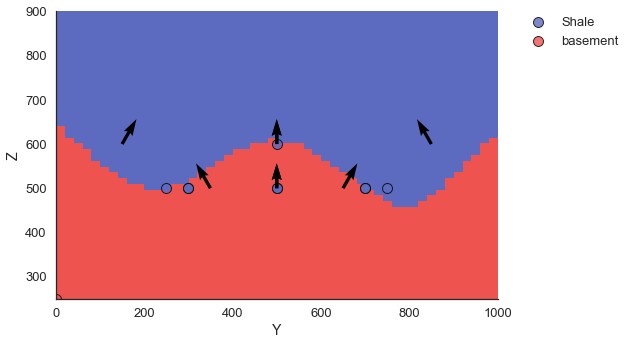

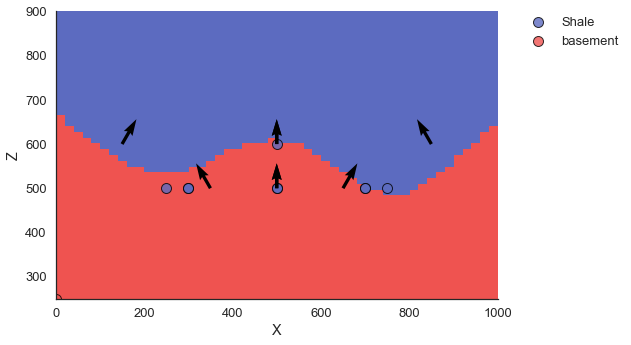

In [31]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

In [ ]:
#for i in range(8):
#    itp_d = interp_unc(z_unc=30, original_values=original_values,start=i)
#    structural_model(interp_data_M=itp_d, shale_n=shale_n, print_figures=True)